<a href="https://colab.research.google.com/github/tejas4888/VQA-685/blob/main/generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive 

def mount_drive():
    drive.mount('/content/drive')

def load_data(path):

    # path = "/content/drive/MyDrive/PathVQA/split/"    

    train_path = path + 'qas/train/'
    test_path = path + 'qas/test/'
    val_path = path + 'qas/val/'

    print ("\nLoading PathVQA")
    train_qa = pd.read_pickle(train_path + "train_qa.pkl")
    test_qa = pd.read_pickle(test_path + "test_qa.pkl")
    val_qa = pd.read_pickle(val_path + "val_qa.pkl")
    ans2label = pd.read_pickle(path+'qas/ans2label.pkl')
    
    train = []
    for row in train_qa:
        if row['answer'] in ans2label:
            train.append([ row['image'], row['question'], int(ans2label[row['answer']]) ] )

    test = []
    for row in test_qa:
        if row['answer'] in ans2label:
            test.append([row['image'], row['question'], int(ans2label[row['answer']]) ])

    val = []
    for row in val_qa:
            if row['answer'] in ans2label:
                val.append([row['image'], row['question'], int(ans2label[row['answer']]) ])

    # train = np.array()

    # return train_qa, test_qa, val_qa, ans2label
    return np.asarray(train), np.asarray(test), np.asarray(val), ans2label

mount_drive()
path = "/content/drive/MyDrive/PathVQA/split/"
train, test, val, ans2label = load_data(path)

Mounted at /content/drive

Loading PathVQA


# Baseline Accuracy

Predict the most common class

In [ ]:
cnts = {}
for i in range(0, len(ans2label)):
    cnts[i] = 0

for example in train:
    label = int(example[2])
    cnts[label]+=1

max = 0
max_idx = 0
for key in cnts:
    if (cnts[key]>max):
        max_idx = key
        max = cnts[key]

print (max_idx, max)

test_baseline_acc = 0.0
for example in test:
    if (int(example[2]) == max_idx):
        test_baseline_acc += 1.0
test_baseline_acc = test_baseline_acc/len(test)

print (f'Baseline test accuracy is {test_baseline_acc}.')

3 5428
Baseline test accuracy is 0.3177119228118539.


# Visualizing Features

In [ ]:
!pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     |████████████████████████████████| 274 kB 13.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=83cefebb7382b701a4fd0287b9512f61b25d3ea7bf4aff3514cb0abb239296b8
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-echxfiqu
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-echxfiqu
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 145 kB 35.6 MB/s 
     |████████████████████████████████| 130 kB 49.1 MB/s 
     |████████████████████████████████| 749 kB 37.0 MB/s 
     |███████

In [ ]:
import sys
import os
from torch.nn import functional as F
import torch, torchvision
import yaml
import json 
import cv2
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
# from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

In [ ]:
class PretrainedCNN:

    def __init__(self, cfg_path):

        self.cfg = self.load_config_and_model_weights(cfg_path)
        self.model = self.get_model(self.cfg)

    def load_config_and_model_weights(self, cfg_path):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

        # ROI HEADS SCORE THRESHOLD
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

        # Comment the next line if you're using 'cuda'
        # cfg['MODEL']['DEVICE']='cpu'

        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

        return cfg

    def get_model(self, cfg):
        # build model
        model = build_model(cfg)

        # load weights
        checkpointer = DetectionCheckpointer(model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        # eval mode
        model.eval()
        return model        

    def prepare_image_inputs(self, img_list):

        #get model's cfg
        cfg = self.cfg 

        # Resizing the image according to the configuration
        transform_gen = T.ResizeShortestEdge([cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST)
        img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

        # Convert to C,H,W format
        convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))

        batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

        # Normalizing the image
        num_channels = len(cfg.MODEL.PIXEL_MEAN)
        pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1)
        pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1)
        normalizer = lambda x: (x - pixel_mean) / pixel_std
        images = [normalizer(x["image"]) for x in batched_inputs]

        # Convert to ImageList
        images =  ImageList.from_tensors(images,self.model.backbone.size_divisibility)
        
        return images, batched_inputs

    def get_visual_embeddings(self, img):

        # with torch.no_grad():
        #     if (self.is_vision_model_loaded == False):
        #         print("Loading CNN\n")
        #         cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
        #         self.cnn = PretrainedCNN(cfg_path)      
        #         # self.cfg = cfg_path
        #         # self.model = PretrainedCNN.get_model(self.cfg)
        #         self.is_vision_model_loaded = True

        cfg = self.cfg
        images, batched_inputs = self.prepare_image_inputs(img)
        
        features = self.model.backbone(images.tensor.cuda())
        proposals, _ = self.model.proposal_generator(images, features)
        
        features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
        return features
        #     box_features = self.model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
        #     box_features = self.model.roi_heads.box_head.flatten(box_features)
        #     box_features = self.model.roi_heads.box_head.fc1(box_features)
        #     box_features = self.model.roi_heads.box_head.fc_relu1(box_features)
        #     box_features = self.model.roi_heads.box_head.fc2(box_features)
        #     # print (box_features.shape)
        #     box_features = box_features.reshape(1, -1, 1024) # depends on your config and batch size
        #     # box_features = box_features.reshape(1, -1, 2048) # depends on your config and batch size
        
        #     cls_features = self.model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
        #     cls_features = self.model.roi_heads.box_head(cls_features)
        #     pred_class_logits, pred_proposal_deltas = self.model.roi_heads.box_predictor(cls_features)

        #     box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
        #     smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

        #     outputs = FastRCNNOutputs(
        #         box2box_transform,
        #         pred_class_logits,
        #         pred_proposal_deltas,
        #         proposals,
        #         smooth_l1_beta,
        #     )

        #     boxes = outputs.predict_boxes()
        #     scores = outputs.predict_probs()
        #     image_shapes = outputs.image_shapes

        #     output_boxes = [self.get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]

        #     temp = [self.select_boxes(output_boxes[i], scores[i]) for i in range(len(scores))]

        #     keep_boxes, max_conf = [],[]
        #     for keep_box, mx_conf in temp:
        #         keep_boxes.append(keep_box)
        #         max_conf.append(mx_conf)

        #     MIN_BOXES=10
        #     MAX_BOXES=100

        #     keep_boxes = [self.filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]
        #     visual_embeds = [ box_feature[keep_box.copy()] for box_feature, keep_box in zip(box_features, keep_boxes)]

        # return visual_embeds

    def get_output_boxes(self, boxes, batched_inputs, image_size):
        proposal_boxes = boxes.reshape(-1, 4).clone()
        scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
        output_boxes = Boxes(proposal_boxes)

        output_boxes.scale(scale_x, scale_y)
        output_boxes.clip(image_size)

        return output_boxes

    def filter_boxes(self, keep_boxes, max_conf, min_boxes, max_boxes):
        
        keep_boxes = keep_boxes.cpu()
        max_conf = max_conf.cpu()

        if len(keep_boxes) < min_boxes:
            keep_boxes = np.argsort(max_conf).numpy()[::-1][:min_boxes]
        elif len(keep_boxes) > max_boxes:
            keep_boxes = np.argsort(max_conf).numpy()[::-1][:max_boxes]
        return keep_boxes


    def select_boxes(self, output_boxes, scores):

        cfg = self.cnn.cfg
        test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
        test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
        cls_prob = scores.detach()
        # print (output_boxes.shape)
        cls_boxes = output_boxes.tensor.detach().reshape(-1,80,4)
        # cls_boxes = output_boxes.tensor.detach().reshape(1000,80,4)
        max_conf = torch.zeros((cls_boxes.shape[0])).to(torch.device("cuda:0"))
        for cls_ind in range(0, cls_prob.shape[1]-1):
            cls_scores = cls_prob[:, cls_ind+1]
            det_boxes = cls_boxes[:,cls_ind,:]
            keep = torch.from_numpy(np.array(nms(det_boxes, cls_scores, test_nms_thresh).cpu())).to(torch.device("cuda:0"))
            max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
        keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
        return keep_boxes, max_conf

    def generate_visual_embeddings(self, data, split='train'):

        img_folder = {'train':path+'images/train/', 'test':path+'images/test/', 'val':path+'images/val/'}
        img_fmt = '.jpg'

        train = data
        i = np.random.randint(0,len(data),1)[0]
        print (i)        
        img_path = img_folder['train'] + train[i][0] + img_fmt
        img = cv2.imread(img_path)
        visual_embeds = self.get_visual_embeddings([img])
        print ("returning")
        return img, visual_embeds

        if (split=='train'):
            train = data
            for i in range(len(train)):    
                if (train[i][0] not in []):
                    img_path = img_folder['train'] + train[i][0] + img_fmt
                    img = cv2.imread(img_path)
                    visual_embeds = self.get_visual_embeddings([img])
                    print ("returning")
                    return img, visual_embeds
                    print ("Now?")
                    self.visual_embeddings[train[i][0]] = visual_embeds
            f = open("/content/drive/MyDrive/CS685/project/train_img_features.pkl","wb")
            pickle.dump(self.visual_embeddings,f)
            f.close()
            
        elif (split=='test'):
            test = data
            self.visual_embeddings = {}
            for i in range(len(test)):    
                if (test[i][0] not in self.visual_embeddings):
                    img_path = img_folder['test'] + test[i][0] + img_fmt
                    img = cv2.imread(img_path)
                    visual_embeds = self.get_visual_embeddings([img])
                    self.visual_embeddings[test[i][0]] = visual_embeds
            f = open("/content/drive/MyDrive/CS685/project/img_features_test.pkl","wb")
            pickle.dump(self.visual_embeddings,f)
            f.close()
        
        else:
            self.visual_embeddings = {}
            for i in range(len(val)):    
                if (val[i][0] not in self.visual_embeddings):
                    img_path = img_folder['val'] + val[i][0] + img_fmt
                    img = cv2.imread(img_path)
                    visual_embeds = self.get_visual_embeddings([img])
                    self.visual_embeddings[val[i][0]] = visual_embeds
            f = open("/content/drive/MyDrive/CS685/project/img_features_val.pkl","wb")
            pickle.dump(self.visual_embeddings,f)
            f.close()


'''
    Extract visual embeddings and save in pickle file
    DONT RUN AGAIN UNLESS NEEDED
'''

cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
cnn = PretrainedCNN(cfg_path)

# path = "/content/drive/MyDrive/PathVQA/split/"
# train, test, val, ans2label = load_data(path)
# print ("Generating visual embeddings")
# cnn.generate_visual_embeddings('train')
# cnn.generate_visual_embeddings('test')

model_final_a3ec72.pkl: 254MB [00:22, 11.2MB/s]                           


In [ ]:
import urllib
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

img_path = '/content/drive/MyDrive/CS685/project/plots_and_figures/'

def viz_features_from_image(url_path, nbr):
    req = urllib.request.urlopen(url_path)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1) # 'Load it as it is'
    disp_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    plt.imshow(disp_img)
    plt.savefig(img_path + f'coco_example_{nbr}.jpg')

    features = cnn.get_visual_embeddings([disp_img])

    it = 1
    for key in features.keys():
        if (key == 'p5' or key == 'p6'):
            plt.imshow(features[key][0,0,:,:].squeeze().cpu().detach().numpy(), cmap='jet')
            # plt.savefig(img_path + f'coco_example_features_{nbr}_{it}.jpg')
            plt.show()
            it += 1

def viz_features_from_dataset(nbr):

    #returns features for a random example in the training set
    img2, features2 = cnn.generate_visual_embeddings(train, 'train')
    disp_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

    plt.imshow(disp_img2)
    plt.savefig(img_path + f'pathvqa_example_{nbr}.jpg')

    it = 1
    for key in features2.keys():
        if (key == 'p5' or key == 'p6'):
            plt.imshow(features2[key][0,0,:,:].squeeze().cpu().detach().numpy(), cmap='jet')
            # plt.savefig(img_path + f'pathvqa_example_features_{nbr}_{it}.jpg')
            plt.show()
            it += 1

viz_features_from_image("https://farm4.staticflickr.com/3539/3634290064_8e2ded65e3_z.jpg", 1)
viz_features_from_image("https://farm8.staticflickr.com/7003/6649994945_c5e92895f7_z.jpg", 2)
viz_features_from_dataset(1)
viz_features_from_dataset(2)

AttributeError: ignored

# Plotting class distribution for training set

Plot a histogram showing the frequency of 100 most frequent classes

In [ ]:
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive 

train_path = '/content/drive/MyDrive/PathVQA/split/qas/'
train_vqa = pd.read_pickle(train_path + "train_vqa.pkl")
train_qa = pd.read_pickle(train_path + "train/train_qa.pkl")

answers = {}

for example in train_qa:

    if (example['answer'] not in answers):
        answers[example['answer']] = 1
    else:
        answers[example['answer']] += 1

answer_types = {}
question_types = {}

for example in train_vqa:

    if (example['answer_type'] not in answer_types):
        answer_types[example['answer_type']] = 1
    else:
        answer_types[example['answer_type']] += 1

    if (example['question_type'] not in question_types):
        question_types[example['question_type']] = 1
    else:
        question_types[example['question_type']] += 1

cnt = []
for answer in answers:
    if answers[answer] >= 10:
        cnt.append([answer, int(answers[answer])])

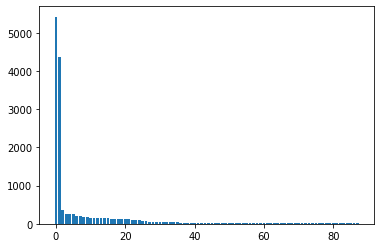

Dataset contains 3 types of answers
Dataset contains 26 types of questions
{'other': 9887, 'yes/no': 9806, 'number': 62}


In [ ]:
x = np.asarray(cnt)[:, 0]
y = np.asarray(cnt)[:, 1]
y = [int(element) for element in y]

sorted_lists = sorted(zip(y,x),reverse=True)
tuples = zip(*sorted_lists)
y,x = [ list(tuple) for tuple in  tuples]

plt.bar(np.arange(len(y)), height=y)
# plt.savefig('/content/drive/MyDrive/CS685/project/plots_and_figures/training_dist.jpg')
plt.show()

print (f'Dataset contains {len(answer_types)} types of answers')
print (f'Dataset contains {len(question_types)} types of questions')
print (answer_types)

# Get test set predictions